In [1]:
import meshio
import numpy as np
from dolfinx import mesh, fem
from mpi4py import MPI
import basix
import pyvista as pv
from dolfinx.io import XDMFFile

[Rohans-MacBook-Pro.local:86963] shmem: mmap: an error occurred while determining whether or not /var/folders/hj/g_ncdftd5lncyq_628n7jckw0000gn/T//ompi.Rohans-MacBook-Pro.501/jf.0/801308672/sm_segment.Rohans-MacBook-Pro.501.2fc30000.0 could be created.


In [3]:
%pip install tetgen pyvista

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tetgen: filename=tetgen-0.6.5-cp313-cp313-macosx_10_13_x86_64.whl size=476464 sha256=af650cf3d72a4c2b30bc53e194cf740281019b2015a816cd200656079a57a3a9
  Stored in directory: /Users/rgopalam/Library/Caches/pip/wheels/5e/65/04/c2b61fbf312cdbab142267acf220dfbbc16a467dca96b53715
Successfully built tetgen
Note: you may need to restart the kernel to use updated packages.


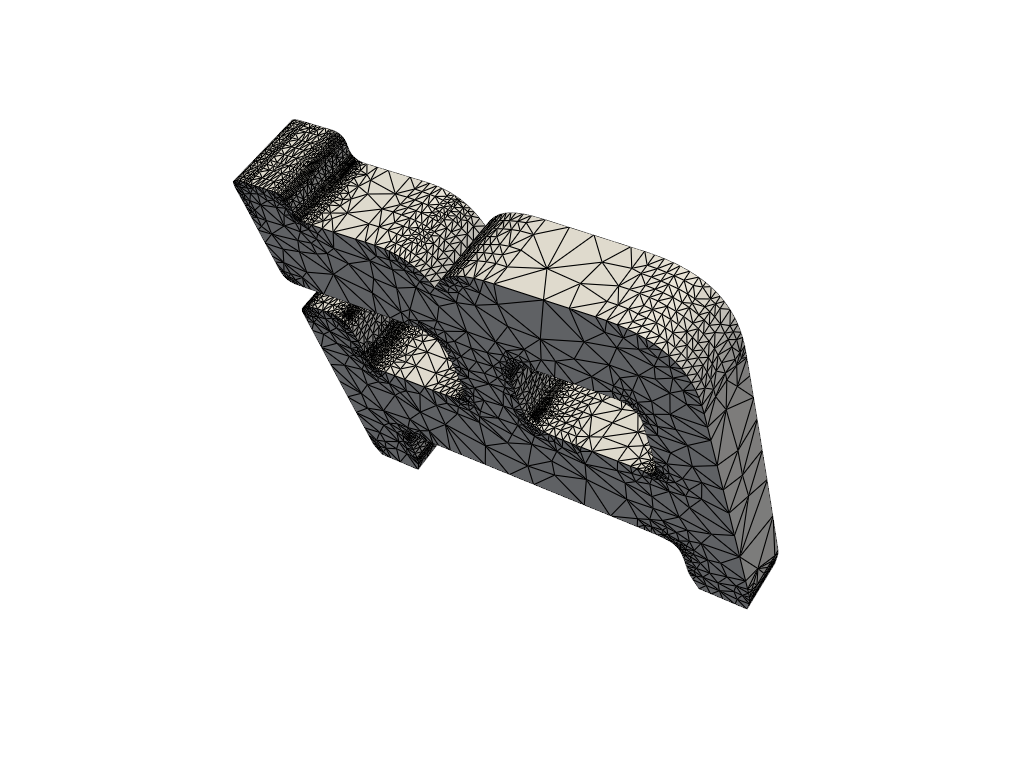

In [7]:
import tetgen

# Read the STL file
input_stl = "test.stl"
surface = pv.read(input_stl)


# Create TetGen object for volumetric meshing
tet = tetgen.TetGen(surface)
tet.tetrahedralize(order=1, mindihedral=10, minratio=1.5)  # Adjust options as needed

# Get the volumetric mesh
mesh_data = tet.grid

# Visualize the volumetric mesh
plotter = pv.Plotter()
plotter.add_mesh(mesh_data, show_edges=True, color="white")
plotter.show()

In [9]:
print(mesh_data.cells_dict.keys())

dict_keys([np.uint8(10)])


In [ ]:
import numpy as np
import meshio
from dolfinx.io import XDMFFile
from mpi4py import MPI

# Specify the XDMF file name
xdmf_file = "converted_mesh.xdmf"

# Map cell types if needed
cell_type_map = {
    np.uint8(10): "tetra",  # Replace "tetra" with the actual type if different
}

# Convert meshio cells to the XDMF format
cells = []
for cell_type, cell_data in mesh_data.cells_dict.items():
    cell_type_str = cell_type_map.get(cell_type, cell_type)
    if not cell_type_str:
        raise ValueError(f"Unknown cell type: {cell_type}. Please map it manually.")
    cells.append((cell_type_str, cell_data))

# Write the XDMF file
meshio.write_points_cells(
    xdmf_file,
    mesh_data.points,
    cells,
    file_format="xdmf",
)

# Load the XDMF file into DOLFINx
with XDMFFile(MPI.COMM_WORLD, xdmf_file, "r") as xdmf:
    domain_mesh = xdmf.read_mesh(name="Grid")  # Ensure the grid name matches the XDMF file
    print(f"Loaded mesh: {domain_mesh.topology.index_map(3).size_local} cells")



Loaded mesh: 427208 cells


In [12]:
from mpi4py import MPI




x_min = domain_mesh.geometry.x[:, 0].min()
x_max = domain_mesh.geometry.x[:, 0].max()

y_min = domain_mesh.geometry.x[:, 1].min()
y_max = domain_mesh.geometry.x[:, 1].max()

z_min = domain_mesh.geometry.x[:, 2].min()
z_max = domain_mesh.geometry.x[:, 2].max()

x_mid = 0.5 * (x_min + x_max)
y_mid = 0.5 * (y_min + y_max)
z_mid = 0.5 * (z_min + z_max)

domain_mesh.geometry.x[:, 0] -= x_mid
domain_mesh.geometry.x[:, 1] -= y_mid
domain_mesh.geometry.x[:, 2] -= z_mid

# Recompute bounds
x_min = domain_mesh.geometry.x[:, 0].min()
x_max = domain_mesh.geometry.x[:, 0].max()

y_min = domain_mesh.geometry.x[:, 1].min()
y_max = domain_mesh.geometry.x[:, 1].max()

z_min = domain_mesh.geometry.x[:, 2].min()
z_max = domain_mesh.geometry.x[:, 2].max()

if MPI.COMM_WORLD.rank == 0:
    print(f"Mesh centered around origin:")
    print(f"X: [{x_min}, {x_max}]")
    print(f"Y: [{y_min}, {y_max}]")
    print(f"Z: [{z_min}, {z_max}]")


if MPI.COMM_WORLD.rank == 0:
    print(f"Mesh bounds:")
    print(f"X: [{x_min}, {x_max}]")
    print(f"Y: [{y_min}, {y_max}]")
    print(f"Z: [{z_min}, {z_max}]")


Mesh centered around origin:
X: [-0.21324491500854492, 0.21324491500854492]
Y: [-0.39824867248535156, 0.39824867248535156]
Z: [-0.34685420989990234, 0.34685420989990234]
Mesh bounds:
X: [-0.21324491500854492, 0.21324491500854492]
Y: [-0.39824867248535156, 0.39824867248535156]
Z: [-0.34685420989990234, 0.34685420989990234]


In [14]:
# Temperature function space (scalar field)
element_temp = basix.ufl.element("Lagrange", domain_mesh.topology.cell_name(), degree=1)
V_T = fem.functionspace(domain_mesh, element_temp)

In [15]:
from dolfinx.fem import Function
from ufl import SpatialCoordinate
import numpy as np

# Parameters for the laser
laser_power = 100.0  # Laser power (arbitrary units)
beam_radius = 0.1  # Beam radius
velocity = [0.1, 0.0, 0.0]  # Laser velocity (m/s)
time_step = 0.01  # Time step (s)
laser_position = [0.0, 0.0, 0.0]  # Initial laser position

# Define the heat source as a Gaussian distribution
x = SpatialCoordinate(domain_mesh)

def moving_heat_source(t):
    current_position = [laser_position[0] + velocity[0] * t,
                        laser_position[1] + velocity[1] * t,
                        laser_position[2] + velocity[2] * t]
    return laser_power * np.exp(-((x[0] - current_position[0])**2 + 
                                  (x[1] - current_position[1])**2) / (2 * beam_radius**2))


In [16]:
# Define the layers
layer_thickness = 0.1  # Thickness of each layer
z_min = domain_mesh.geometry.x[:, 2].min()
z_max = domain_mesh.geometry.x[:, 2].max()

layers = np.arange(z_min, z_max, layer_thickness)

# Function to select elements in a given layer
def layer_filter(layer_z):
    return np.logical_and(
        domain_mesh.geometry.x[:, 2] >= layer_z,
        domain_mesh.geometry.x[:, 2] < layer_z + layer_thickness
    )


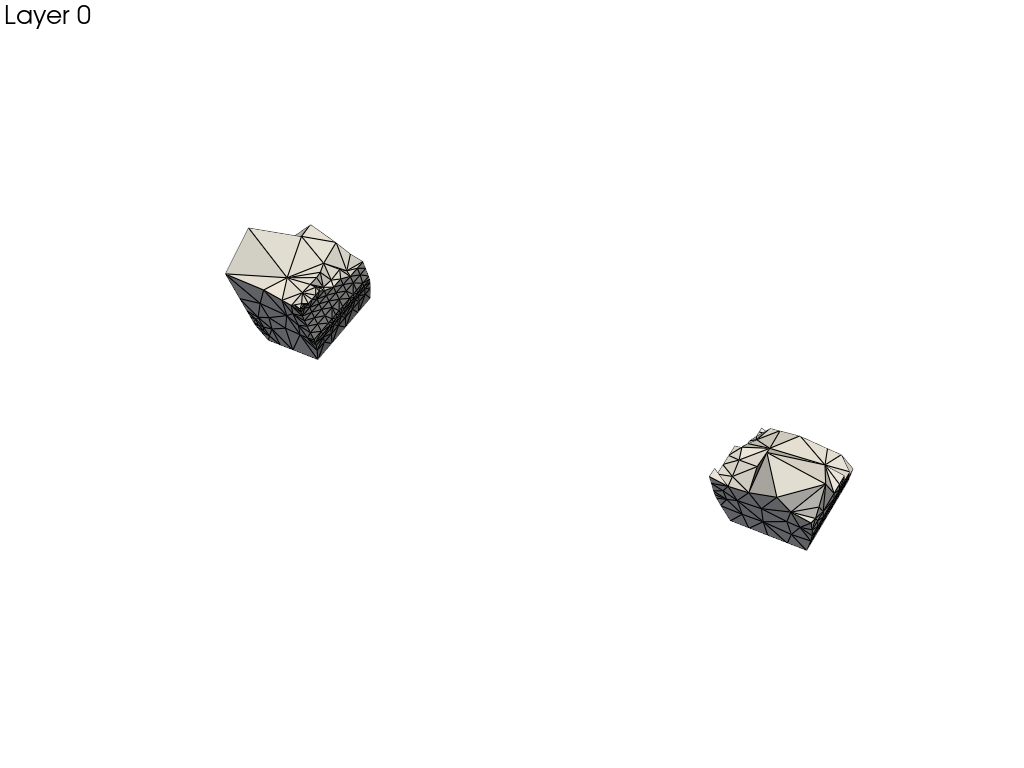

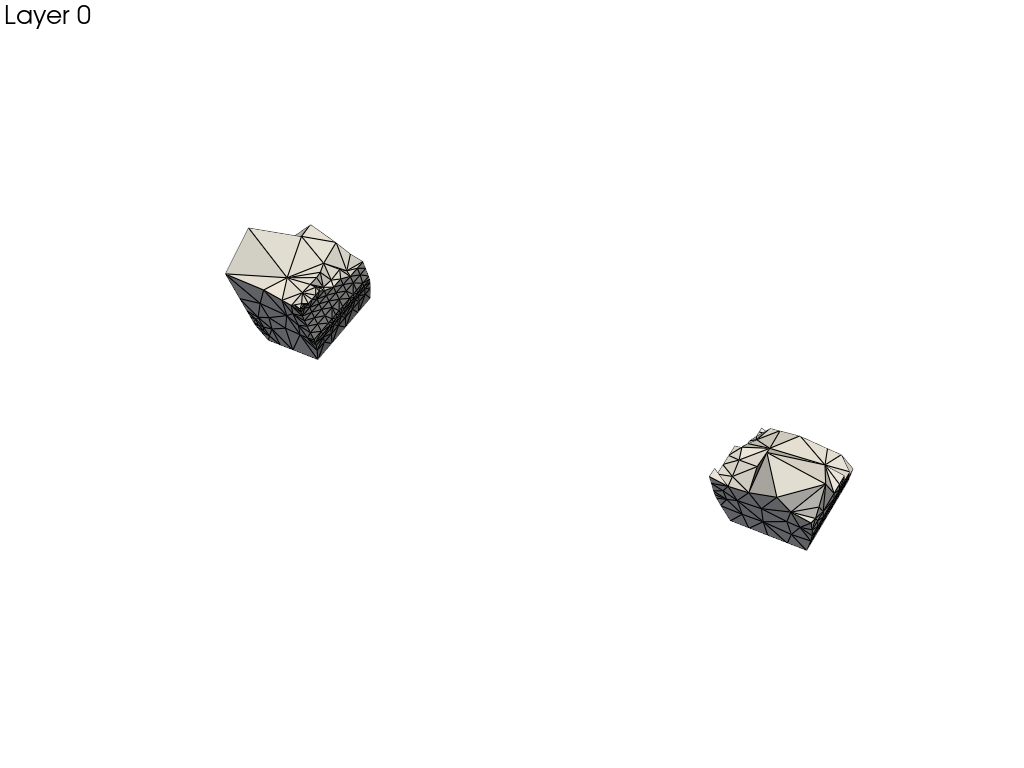

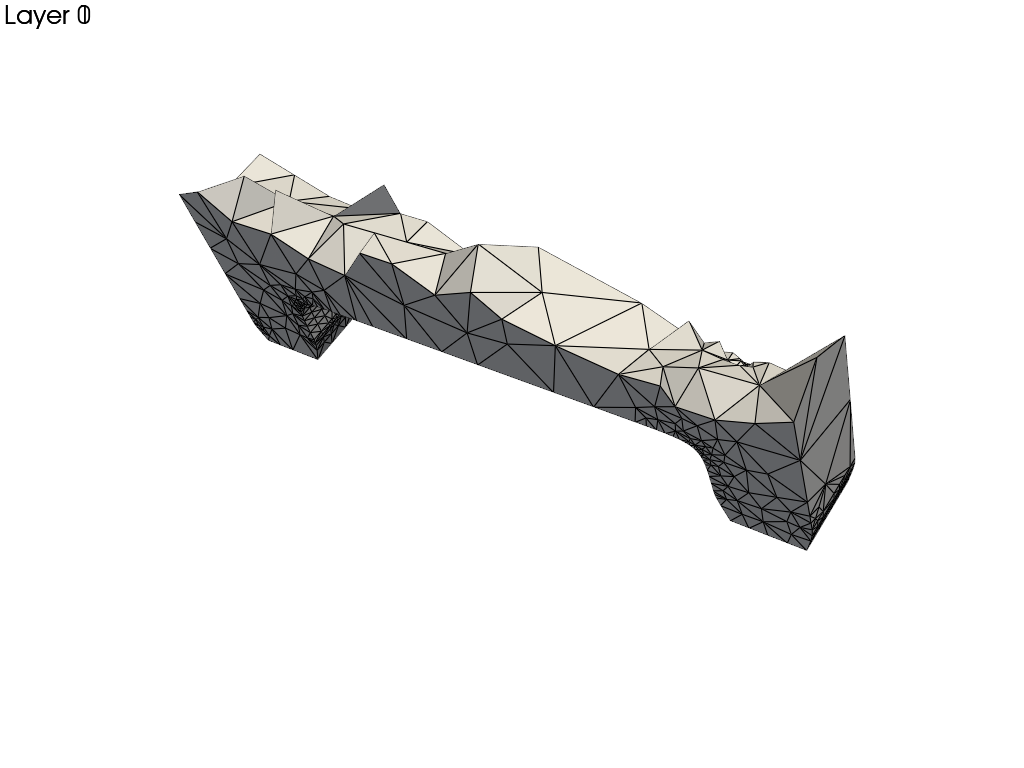

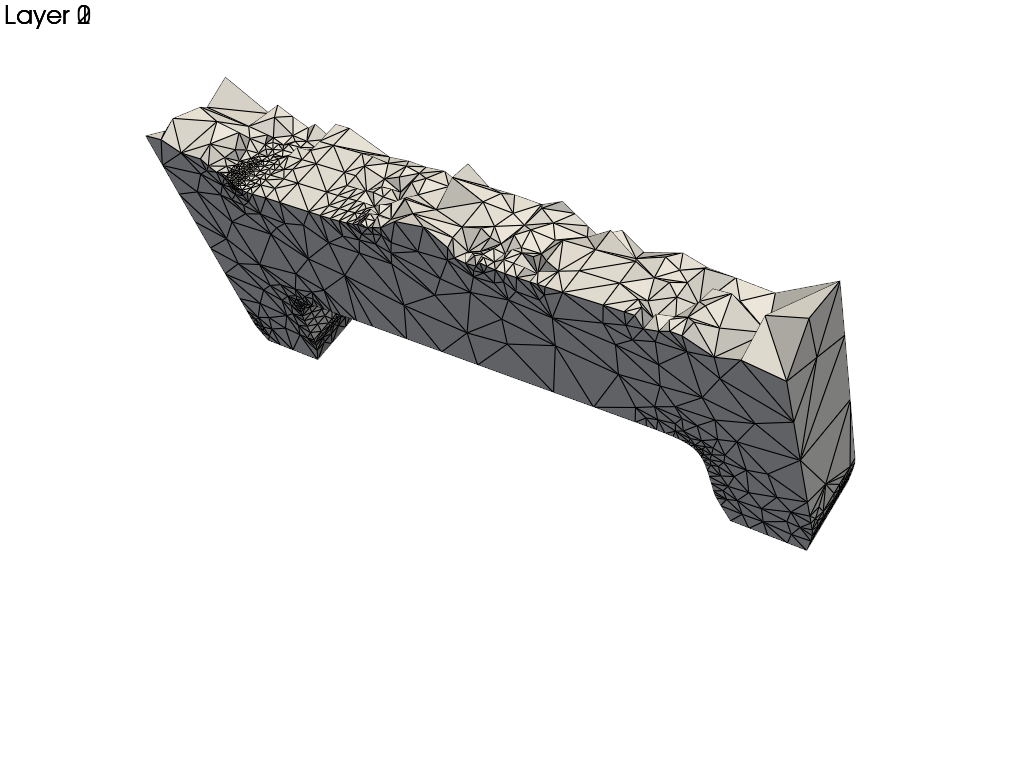

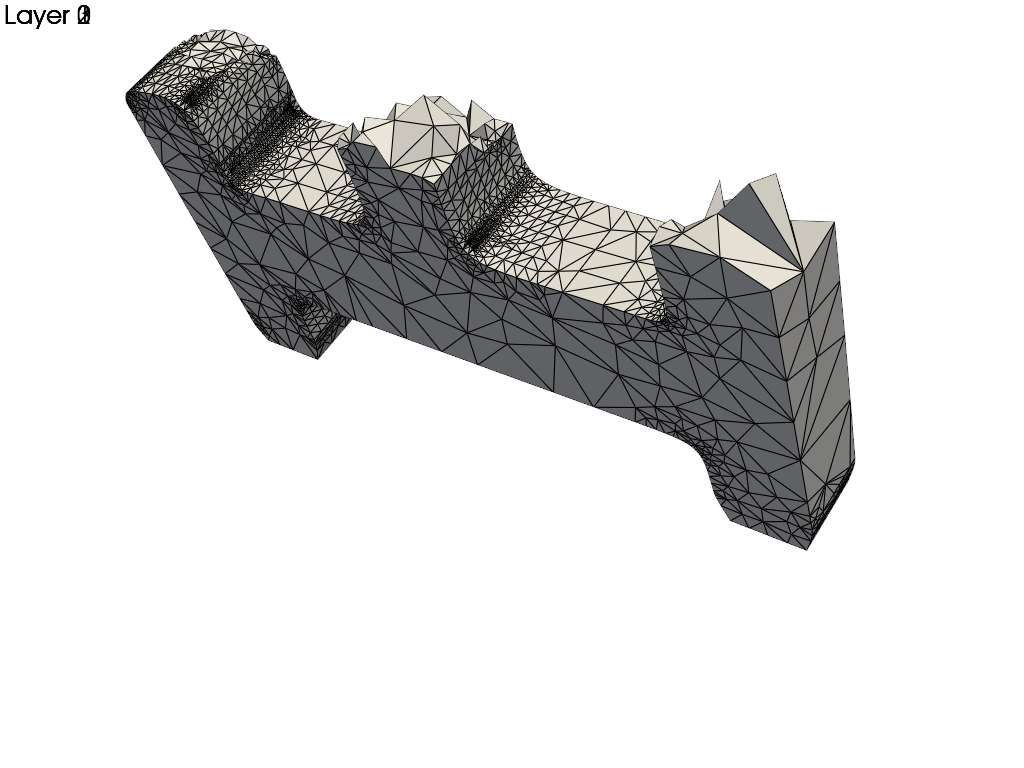

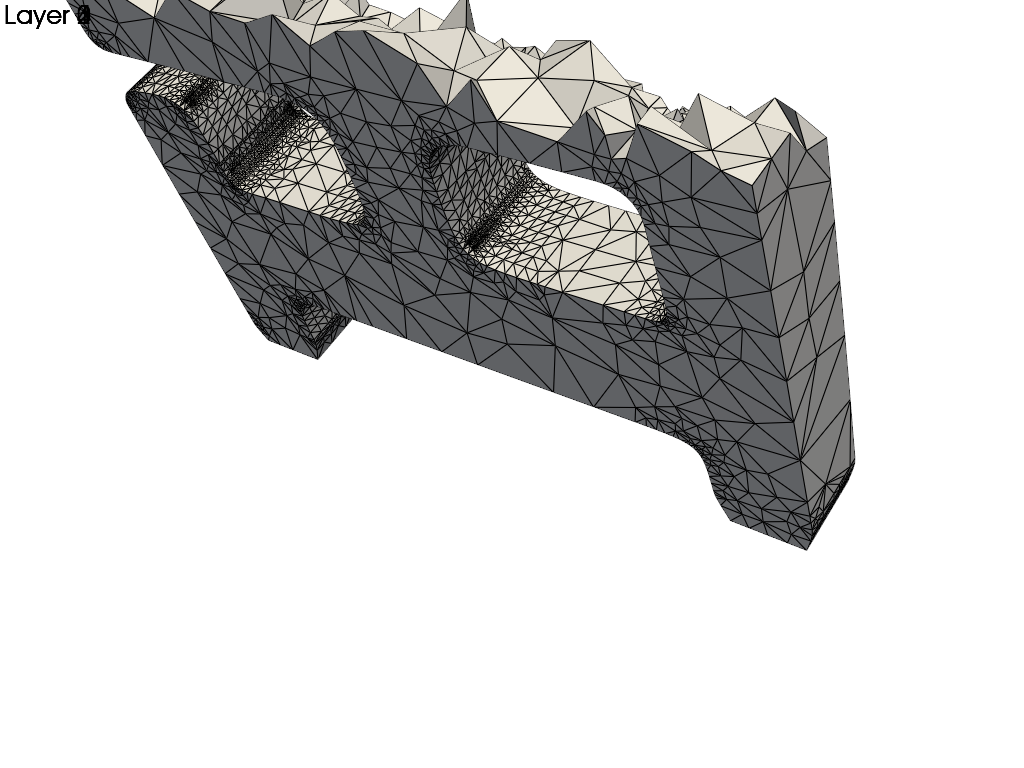

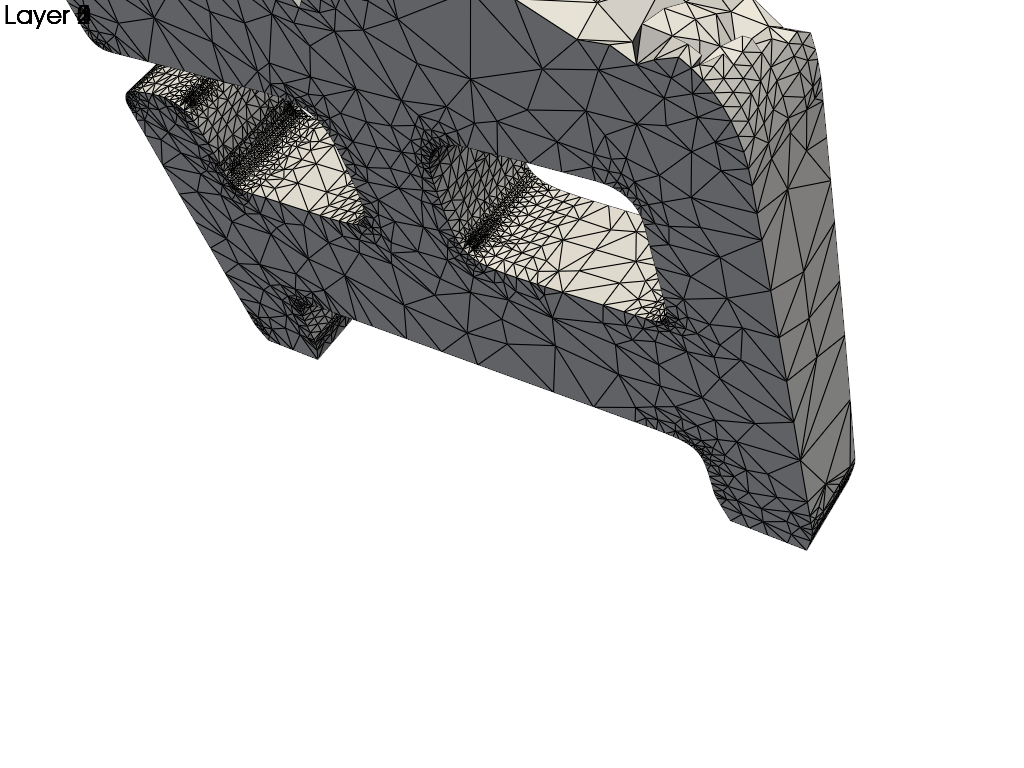

In [21]:
import pyvista as pv
from dolfinx.plot import vtk_mesh
import numpy as np

# Convert Dolfinx mesh to PyVista UnstructuredGrid
topology, cell_types, geometry = vtk_mesh(domain_mesh)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Layer settings
layer_thickness = 0.1  # Adjust layer size
z_min, z_max = geometry[:, 2].min(), geometry[:, 2].max()
layers = np.arange(z_min, z_max, layer_thickness)

# PyVista Plotter
plotter = pv.Plotter()

for i, layer_z in enumerate(layers):
    # Filter points in the current layer based on z-coordinate
    layer_filter = np.logical_and(
        geometry[:, 2] >= layer_z,
        geometry[:, 2] < layer_z + layer_thickness
    )
    
    # Extract layer points and cells
    layer_indices = np.where(layer_filter)[0]
    layer_grid = grid.extract_points(layer_indices)
    
    # Add the layer to the plotter
    plotter.add_mesh(
        layer_grid,
        show_edges=True,
        color="white",
        label=f"Layer {i}"
    )

    
    plotter.add_text(f"Layer {i}", position="upper_left", font_size=10)
    # Show mesh progression
    plotter.show()



In [ ]:
from dolfinx.fem import Function, form, dirichletbc, locate_dofs_geometrical
from ufl import TrialFunction, TestFunction, grad, dot, dx
from dolfinx.fem.petsc import LinearProblem

# Trial and test functions
u = TrialFunction(V_T)
v = TestFunction(V_T)

# Initial temperature field
temperature = Function(V_T)
temperature.interpolate(lambda x: np.zeros_like(x[0]))  # Initial temperature = 0

# Time-stepping loop over layers
for layer_z in layers:
    # Restrict to the current layer
    mask = layer_filter(layer_z)
    active_elements = np.where(mask)[0]
    
    # Define the heat equation weak form for the current layer
    source = moving_heat_source(0)  # Use the heat source at the current time
    kappa = 1.0  # Thermal conductivity
    c = 1.0  # Specific heat capacity
    rho = 1.0  # Density
    
    a = kappa * dot(grad(u), grad(v)) * dx
    L = source * v * dx + c * rho * temperature * v * dx
    
    # Solve for temperature in the current layer
    problem = LinearProblem(a, L)
    temperature.assign(problem.solve())
    


In [ ]:
import ufl
import numpy as np
from dolfinx.fem.petsc import LinearProblem

# Trial and test functions for temperature
T = ufl.TrialFunction(V_T)
v_T = ufl.TestFunction(V_T)

# Thermal conductivity, heat source
Q = fem.Function(V_T)  # Heat source (moving laser in LBPF)
rho = 7800  # Density
cp = 500  # Specific heat capacity
k = 45  # Thermal conductivity

# Boundary conditions for temperature
T_bc = fem.Function(V_T)
T_bc.interpolate(lambda x: np.full(x.shape[1], 300.0))  # Fixed boundary temperature
boundary_facets_T = mesh.locate_entities_boundary(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0)
)
boundary_dofs_T = fem.locate_dofs_topological(V_T, domain_mesh.topology.dim - 1, boundary_facets_T)
bc_T = fem.dirichletbc(T_bc, boundary_dofs_T)

# Initialize temperature solution and previous temperature field
T_sol_moving = fem.Function(V_T)  # Current solution
T_prev = fem.Function(V_T)  # Previous step solution (initial condition)
T_prev.interpolate(lambda x: np.full(x.shape[1], 300.0))  # Initial temperature (300 K)

# Define the moving Gaussian heat source
def moving_gaussian_heat_source(x, t, z_layer):
    # Laser path: moves in the x-direction over time
    center = np.array([0.1 + 0.05 * t, 0.5, z_layer])  # Center moves over x and is layer-dependent in z
    intensity = 1e6  # Heat intensity (W/m^3)
    radius = 0.1  # Laser radius (m)
    r = np.linalg.norm(x - center[:, np.newaxis], axis=0)  # Distance from moving center
    result = intensity * np.exp(-r**2 / (2 * radius**2))  # Gaussian distribution
    return result

# Time-stepping and layer parameters
num_layers = 5  # Total number of layers
layer_height = 0.1  # Height of each layer
t_layer = 2.0  # Time for processing one layer
dt = 0.1       # Time step size within a layer
num_steps_per_layer = int(t_layer / dt)

# Layer-by-layer simulation
for layer in range(num_layers):
    z_layer = layer * layer_height  # Current layer height in the z-direction
    print(f"Simulating layer {layer + 1}/{num_layers} at z = {z_layer}")

    for step in range(num_steps_per_layer):
        t = step * dt  # Time within the current layer

        # Update the heat source for the current layer and time step
        Q.interpolate(lambda x: moving_gaussian_heat_source(x, t, z_layer))

        # Weak form of the transient heat equation
        a_T = (rho * cp / dt) * T * v_T * ufl.dx + k * ufl.dot(ufl.grad(T), ufl.grad(v_T)) * ufl.dx
        L_T = (rho * cp / dt) * T_prev * v_T * ufl.dx + Q * v_T * ufl.dx

        # Solve for the current temperature field
        temp_problem = LinearProblem(a_T, L_T, bcs=[bc_T])
        T_sol_moving = temp_problem.solve()

        # Update T_prev for the next time step within the layer
        T_prev.x.array[:] = T_sol_moving.x.array[:]

    # After finishing the current layer, retain the temperature field for the next layer
    print(f"Layer {layer + 1} completed. Updating temperature field for the next layer.")
    T_prev.assign(T_sol_moving)

In [ ]:
import numpy as np
import ufl
from mpi4py import MPI
from dolfinx.io import XDMFFile
from dolfinx.fem import Function, FunctionSpace, dirichletbc
from dolfinx.fem.petsc import LinearProblem
from dolfinx.cpp.fem import adapt


V_T = FunctionSpace(domain_mesh, ("CG", 1))


# Material properties
rho = 7800  # Density (kg/m³)
cp = 500    # Specific heat capacity (J/kg·K)
k = 45      # Thermal conductivity (W/m·K)

# Simulation parameters
t_start, t_end = 0.0, 1.0  # Time range (seconds)
dt = 0.1                   # Timestep size (seconds)
num_layers = 5             # Number of layers
layer_height = 0.1         # Height of each layer (m)

# Initialize temperature field
T_prev = Function(V_T)
T_prev.interpolate(lambda x: np.full(x.shape[1], 300.0))  # Initial temperature (300 K)

# Define heat source as a moving Gaussian
def moving_gaussian_heat_source(x, t, center_x=0.1, speed=0.05):
    """Gaussian heat source that moves along the x-direction."""
    center = np.array([center_x + speed * t, 0.5])  # Move in x
    intensity = 1e6                                # Heat source intensity
    radius = 0.1                                   # Laser beam radius
    r = np.linalg.norm(x - center[:, np.newaxis], axis=0)
    return intensity * np.exp(-r**2 / (2 * radius**2))


# Loop over layers
for layer in range(num_layers):
    print(f"Simulating Layer {layer + 1}/{num_layers}")
    
    # Add a new layer by extending the mesh
    new_height = layer_height + (layer + 1) * layer_height
    domain_mesh = dolfinx.cpp.fem.adapt(domain_mesh, new_coordinates=np.array([0.0, 0.0, 1.0, new_height]))
    
    # Update function space for the new mesh
    V_T = FunctionSpace(domain_mesh, ("CG", 1))
    
    # Interpolate previous solution to the new mesh
    T_prev = Function(V_T)
    T_prev.interpolate(lambda x: np.full(x.shape[1], 300.0))  # Initial temperature (300 K)

    # Time-stepping for the current layer
    for step in range(int((t_end - t_start) / dt)):
        t = t_start + step * dt  # Current time

        # Heat source for the current timestep
        Q = Function(V_T)
        Q.interpolate(lambda x: moving_gaussian_heat_source(x, t))

        # Define weak form of the heat equation
        T = ufl.TrialFunction(V_T)
        v_T = ufl.TestFunction(V_T)
        a_T = rho * cp * T * v_T * ufl.dx + k * ufl.dot(ufl.grad(T), ufl.grad(v_T)) * ufl.dx
        L_T = rho * cp * T_prev * v_T * ufl.dx + Q * v_T * ufl.dx

        # Solve the temperature field
        temp_problem = LinearProblem(a_T, L_T)
        T_sol = temp_problem.solve()

        # Update T_prev for the next timestep
        T_prev.x.array[:] = T_sol.x.array[:]




TypeError: FunctionSpace.__init__() missing 1 required positional argument: 'cppV'

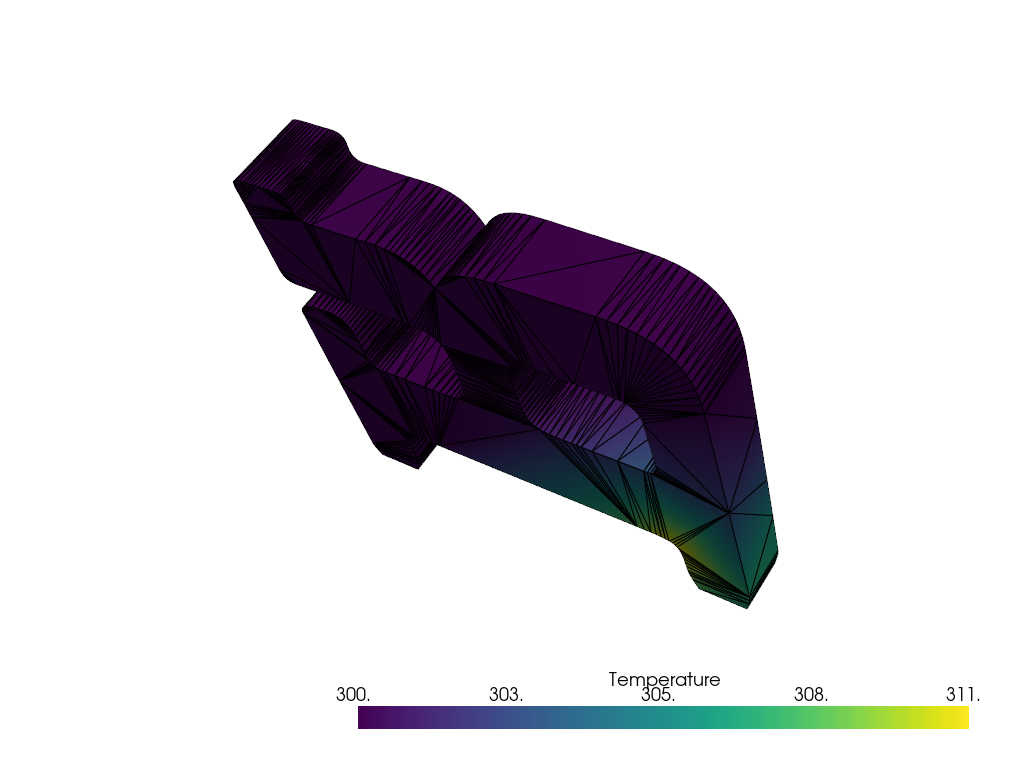

Max Temperature: 310.91048158986416
Min Temperature: 299.8535102730689


In [ ]:
import pyvista as pv
from dolfinx.plot import vtk_mesh

# Visualize
topology, cell_types, geometry = vtk_mesh(domain_mesh)

grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Add displacement
grid.point_data["Temperature"] = T_sol_moving.x.array.reshape(geometry.shape[0], -1)  # Reshape to match the mesh points

# Plot field
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, scalars="Temperature", cmap="viridis")
plotter.show()

print(f"Max Temperature: {T_sol_moving.x.array.max()}")
print(f"Min Temperature: {T_sol_moving.x.array.min()}")


In [12]:
# convert to lagrange element
element = basix.ufl.element(
    "Lagrange", domain_mesh.topology.cell_name(), degree=1, shape=(domain_mesh.geometry.dim,)
)

# displacement function
V = fem.functionspace(domain_mesh, element)

In [21]:
import ufl
import numpy as np
from petsc4py import PETSc

# Define the finite element for displacement (vector field)
element_disp = basix.ufl.element(
    "Lagrange", domain_mesh.topology.cell_name(), degree=1, shape=(domain_mesh.geometry.dim,)
)

# Define the function space for displacement
V_u = fem.functionspace(domain_mesh, element_disp)

# Define trial and test functions for displacement
u = ufl.TrialFunction(V_u)  # Trial function (solution approximation for displacement)
v_u = ufl.TestFunction(V_u)  # Test function (used in weak form)

In [ ]:
# Mechanical properties
E = 210e9   # Young's modulus (Pa)
nu = 0.3    # Poisson's ratio
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

# Define strain and stress tensors
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Strain tensor

def sigma(u):
    return (
        lambda_ * ufl.tr(epsilon(u)) * ufl.Identity(len(u)) +
        2 * mu * epsilon(u)
    )


In [15]:
# 6. Weak Forms
# Heat transfer weak form
Q = fem.Function(V_T)  # Laser heat source (to be defined later)
a_T = rho * cp * T * v_T * ufl.dx + k * ufl.dot(ufl.grad(T), ufl.grad(v_T)) * ufl.dx
L_T = Q * v_T * ufl.dx



In [16]:
# Set up boundary conditions
# 1. Temperature Dirichlet BC (fixed temperature at x=0)
T_bc = fem.Function(V_T)
T_bc.interpolate(lambda x: np.full(x.shape[1], 300.0))  # Fixed temperature at 300K
boundary_facets_T = mesh.locate_entities_boundary(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0)
)
boundary_dofs_T = fem.locate_dofs_topological(V_T, domain_mesh.topology.dim - 1, boundary_facets_T)
bc_T = fem.dirichletbc(T_bc, boundary_dofs_T)

# 2. Displacement Dirichlet BC (fix displacement at x=0)
u_bc = fem.Function(V_u)
u_bc.interpolate(lambda x: np.zeros((domain_mesh.geometry.dim, x.shape[1])))  # Zero displacement
boundary_facets_u = mesh.locate_entities_boundary(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0)
)
boundary_dofs_u = fem.locate_dofs_topological(V_u, domain_mesh.topology.dim - 1, boundary_facets_u)
bc_u = fem.dirichletbc(u_bc, boundary_dofs_u)

In [ ]:

# Material properties
E = 210e9  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio

# Lame parameters
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

# Define strain and stress
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Strain tensor

def sigma(u, T=None):
    # Optionally include thermal expansion from temperature (coupling)
    if T is not None:
        alpha = 12e-6  # Thermal expansion coefficient
        T_ref = 300.0  # Reference temperature
        return (
            lambda_ * ufl.tr(epsilon(u)) * ufl.Identity(len(u))
            + 2 * mu * epsilon(u)
            - alpha * E * (T - T_ref) * ufl.Identity(len(u))
        )
    return lambda_ * ufl.tr(epsilon(u)) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)


In [20]:
# Solve Temperature
from dolfinx.fem.petsc import LinearProblem

# Solve temperature field
temp_problem = LinearProblem(a_T, L_T, bcs=[bc_T])
T_sol = temp_problem.solve()


T_expr = fem.Function(V_T)
T_expr.x.array[:] = T_sol.x.array[:]

# Elasticity weak form (temperature-dependent stress)
f = fem.Constant(domain_mesh, PETSc.ScalarType((0.0, 0.0, -9.81)))  # Body force
a_u = ufl.inner(sigma(u, T_expr), epsilon(v_u)) * ufl.dx
L_u = ufl.inner(f, v_u) * ufl.dx


# Solve Displacement
disp_problem = LinearProblem(a_u, L_u, bcs=[bc_u])
u_disp = disp_problem.solve()

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
import pyvista as pv
from dolfinx.plot import create_vtk_mesh

# Create the VTK mesh for visualization
topology, cell_types, geometry = create_vtk_mesh(domain_mesh)

# Initialize a PyVista UnstructuredGrid
grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Add the displacement field to the mesh
grid.point_data["Displacement"] = u_disp.x.array.reshape(geometry.shape[0], -1)  # Reshape to match the mesh points

# Add the temperature field to the mesh
grid.point_data["Temperature"] = T_sol.x.array  # Direct assignment for scalar fields

# Create a plotter
plotter = pv.Plotter()

# Plot the displacement field
plotter.add_mesh(grid.copy(), scalars="Displacement", show_edges=True, cmap="coolwarm")
plotter.add_scalar_bar(title="Displacement Magnitude")

# Plot the temperature field on the same grid
plotter.add_mesh(grid.copy(), scalars="Temperature", show_edges=False, cmap="viridis")
plotter.add_scalar_bar(title="Temperature")

# Show the plot
plotter.show()


In [6]:
# Define trial and test functions
u = ufl.TrialFunction(V)  # Displacement field
v = ufl.TestFunction(V)

# Body force (e.g., gravity in z-direction)
f = fem.Constant(domain_mesh, PETSc.ScalarType((0.0, 0.0, -9.81)))

# Weak form
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx 

In [7]:
# Boundary conditions
u_bc = fem.Function(V)
u_bc.interpolate(lambda x: np.zeros((domain_mesh.geometry.dim, x.shape[1])))

boundary_facets = mesh.locate_entities_boundary(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0)
)
boundary_dofs = fem.locate_dofs_topological(V, domain_mesh.topology.dim - 1, boundary_facets)
bc = fem.dirichletbc(u_bc, boundary_dofs)

In [8]:
# Solve
from dolfinx.fem.petsc import LinearProblem

problem = fem.petsc.LinearProblem(a, L, bcs=[bc])
u_sol = problem.solve()

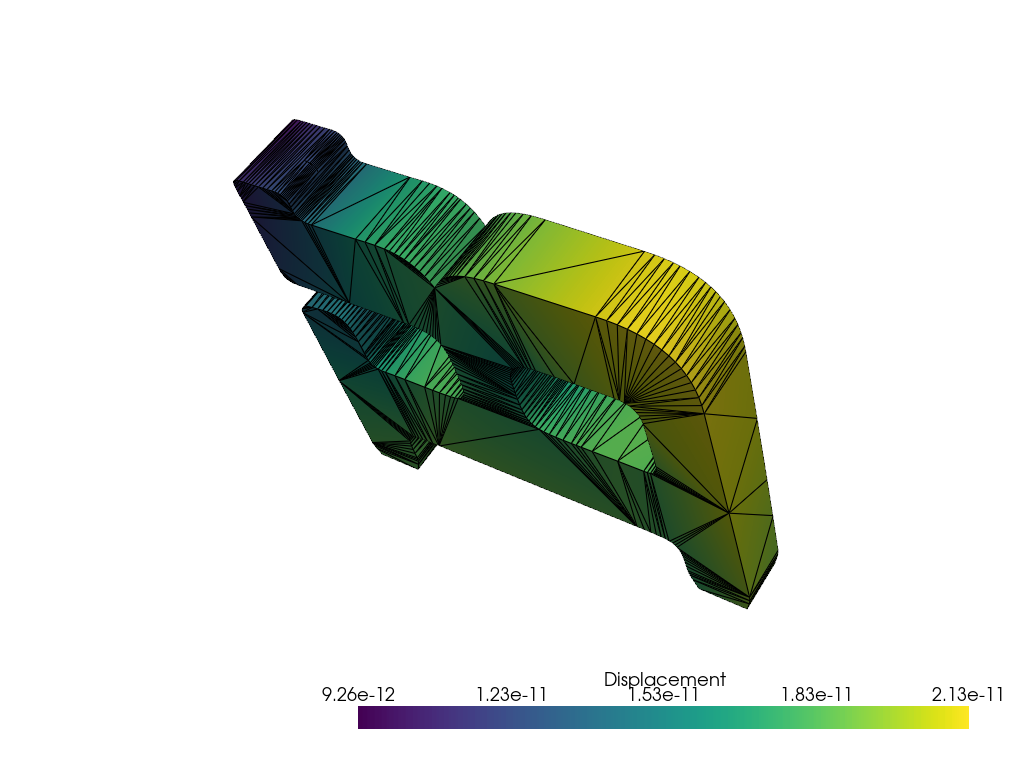

In [9]:
import pyvista as pv
from dolfinx.plot import vtk_mesh

# Visualize
topology, cell_types, geometry = vtk_mesh(domain_mesh)

grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Add displacement
grid.point_data["Displacement"] = u_sol.x.array.reshape(geometry.shape[0], -1)  # Reshape to match the mesh points

# Plot field
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, scalars="Displacement", cmap="viridis")
plotter.show()